In [1]:
#import sweetviz as sv
import pandas as pd
#import dtale
#import numpy as np
#from sdmetrics.reports.multi_table import QualityReport
%matplotlib inline


import os
import json

from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
#import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import seaborn as sns
import numpy as np
from functions import condense_category
#from pycaret.anomaly import *

In [2]:


df_triage = pd.read_excel('..\..\data\St. Olavs ED 2010-2022.xlsx',sheet_name='Data')
  
df_triage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304997 entries, 0 to 304996
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   akdb_InnAkutt                 304997 non-null  datetime64[ns]
 1   akdb_UtAkutt                  304997 non-null  datetime64[ns]
 2   akdb_AkuttGruppeBeskrivelse   304997 non-null  object        
 3   akdb_HastegradBeskrivelse     304233 non-null  object        
 4   akdb_UtskrevetTilBeskrivelse  304807 non-null  object        
 5   akdb_ESS                      304637 non-null  object        
 6   pasient_Fødselsdato           297466 non-null  object        
 7   pasient_Dødsdato              82325 non-null   object        
 8   pasient_kjønn                 297464 non-null  object        
 9   nimes_FagområdeBeskrivelse    238197 non-null  object        
 10  nimes_IK4489Kode              238203 non-null  object        
 11  nimes_IK4489B

In [3]:

df_icd10Kapittel = pd.read_csv("..\..\data\ICD10Kapittel.csv",sep='\t' 
 )
df_icd10Kapittel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21956 entries, 0 to 21955
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   KodeID       21956 non-null  object 
 1   KodeNavn     21955 non-null  object 
 2   Tekst        21955 non-null  object 
 3   Niva0ID      21956 non-null  object 
 4   Niva0Navn    21956 non-null  object 
 5   Niva0SortID  397 non-null    float64
 6   Niva1ID      21933 non-null  object 
 7   Niva1Navn    21933 non-null  object 
 8   Niva2ID      21683 non-null  object 
 9   Niva2Navn    21683 non-null  object 
 10  Niva3ID      21678 non-null  object 
 11  Niva3Navn    21677 non-null  object 
 12  Niva4ID      21660 non-null  object 
 13  Niva4Navn    21660 non-null  object 
 14  MNiva        21944 non-null  float64
 15  LasteSeq     390 non-null    float64
dtypes: float64(3), object(13)
memory usage: 2.7+ MB


In [4]:
df_icd10Kapittel.head()

,KodeID,KodeNavn,Tekst,Niva0ID,Niva0Navn,Niva0SortID,Niva1ID,Niva1Navn,Niva2ID,Niva2Navn,Niva3ID,Niva3Navn,Niva4ID,Niva4Navn,MNiva,LasteSeq
0,-2,Ikke valgt/registrert,Ikke valgt/registrert,-2,Ikke valgt/registrert,1.0,-2,Ikke valgt/registrert,-2,Ikke valgt/registrert,-2,Ikke valgt/registrert,-2,Ikke valgt/registrert,1.0,NaN
1,-1,Ukjent,Ukjent,-1,Ukjent,1.0,-1,Ukjent,-1,Ukjent,-1,Ukjent,-1,Ukjent,1.0,NaN
2,Kapittel I (A00-B99),Kapittel I (A00-B99) - Visse infeksjonssykdomm...,Visse infeksjonssykdommer og parasittsykdommer,Kapittel I (A00-B99),Kapittel I (A00-B99) - Visse infeksjonssykdomm...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3,(A00-A09),(A00-A09) - Infeksiøse tarmsykdommer,Infeksiøse tarmsykdommer,Kapittel I (A00-B99),Kapittel I (A00-B99) - Visse infeksjonssykdomm...,1.0,(A00-A09),(A00-A09) - Infeksiøse tarmsykdommer,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
4,A00,A00 - Kolera (cholera),A00 - Kolera (cholera),Kapittel I,Kapittel I - (A00-B99) Visse infeksjonssykdomm...,NaN,A00-A09,A00-A09 - Infeksiøse tarmsykdommer,A00,A00 - Kolera (cholera),A00,A00 - Kolera (cholera),A00,A00 - Kolera (cholera),3.0,NaN


## Fearure enginering

In [89]:
df_triage_t = df_triage.copy()



In [90]:
df = pd.merge(df_triage, df_icd10Kapittel, how='left', left_on=['nimes_PDXKoder'], right_on=['KodeID'])
df['ICD10Kapittel'] =  np.where(df['Niva0ID'].isnull(), df['nimes_PDXKoder'], df['Niva0ID']) 
df_triage_t['ICD10Kapittel']  = df[['ICD10Kapittel']].apply(condense_category,min_freq=0.0001, new_name="andre",axis=0)
df_triage_t.ICD10Kapittel.value_counts()

Kapittel XVIII            48819
Kapittel IX               34838
Kapittel XIX              31009
Kapittel XI               26856
Kapittel X                20249
Kapittel XIV              15447
Kapittel XIII             11562
Kapittel VI                9554
Kapittel V                 7648
Kapittel I                 7157
Kapittel II                6722
Kapittel XXI               3650
Kapittel IV                3461
Kapittel XII               3258
Kapittel III               1893
Kapittel VIII              1729
andre                      1038
T4N                         894
Kapittel VII                755
Kapittel XV                 496
Kapittel XXI (Z00-Z99)      421
Kapittel XVII               197
G301;F001                   123
Kapittel V (F00-F99)        110
T887                         83
M511;G551                    82
Kapittel XI (K00-K93)        40
T4n;N05AH04                  31
T4n;N02BE01                  28
G301;F0010                   27
I509;J91                     26
Name: IC

In [91]:
#import datetime
#time = datetime.datetime.strptime(triage.Time_in, '%H:%M:%S')
#print (time.hour, time.minute, time.seconde)


In [92]:
#df_triage_t["Htriage"].value_counts().plot(kind='bar')

In [93]:


#Some have missing birthdate
df_triage_t = df_triage_t.dropna(subset=['pasient_Fødselsdato'], how = 'all')

#Remove EDLOS large than 24 hours, and negative values
df_triage_t['EDLOS'] = (df_triage_t.akdb_UtAkutt - df_triage_t.akdb_InnAkutt).dt.total_seconds()/60
df_triage_t = df_triage_t[(df_triage_t.EDLOS < 24*60) & (df_triage_t.EDLOS>0)]

#Calculate Age
df_triage_t['pasient_Fødselsdato'] = pd.to_datetime(df_triage_t['pasient_Fødselsdato'],format='%d.%m.%Y')
df_triage_t['pasient_Dødsdato'] = pd.to_datetime(df_triage_t['pasient_Dødsdato'],format='%d.%m.%Y')
df_triage_t['Alder'] = ((df_triage_t.akdb_InnAkutt - df_triage_t.pasient_Fødselsdato).dt.days/365).apply(lambda x: int(round(x)))

#Define 24 hours mortality and Discharged to ICU or surgery
df_triage_t['30dmrt'] = np.where((df_triage_t.pasient_Dødsdato - df_triage_t.akdb_InnAkutt).dt.days <= 30,1,0)
df_triage_t['24hmrt'] = np.where((df_triage_t.pasient_Dødsdato - df_triage_t.akdb_InnAkutt).dt.days <= 1,1,0)
df_triage_t['DischICU'] = np.where(df_triage_t.akdb_UtskrevetTilBeskrivelse.isin(['INTENSIV','OPERASJON','BABIS','HMO','Recovery','KITOV','LUOS','MLO','NKINT']),1,0)

#Time variables
df_triage_t['Time_in_Hour'] = df_triage_t.akdb_InnAkutt.dt.hour
df_triage_t ['Ukedag'] = df_triage_t.akdb_InnAkutt.dt.dayofweek.map({0:'Mandag',1:'Tirsdag',2:'Onsdag',3:'Torsdag',4:'Fredag',5:'Lørdag',6:'Søndag'})

#Combine variable to be used as a target
df_triage_t['Mrt_AND_OR_ICU'] = np.where(df_triage_t['24hmrt'] + df_triage_t['DischICU'] > 0,1,0)
df_triage_t['Dischhome'] = np.where(df_triage_t.akdb_UtskrevetTilBeskrivelse.isin(['KAD','Sykehjem','MOTP','MOTPKIR','MOTS']),1,0)

In [94]:
df_triage_t = df_triage_t.loc[(df_triage_t['30dmrt']==1) & (df_triage_t.DischICU==1)]
#df_triage_t = df_triage_t.loc[df_triage_t.Mrt_AND_OR_ICU==1]
#df_triage_t = df_triage_t.loc[df_triage_t['Dischhome']==1]
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1725 entries, 930 to 304954
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   akdb_InnAkutt                 1725 non-null   datetime64[ns]
 1   akdb_UtAkutt                  1725 non-null   datetime64[ns]
 2   akdb_AkuttGruppeBeskrivelse   1725 non-null   object        
 3   akdb_HastegradBeskrivelse     1718 non-null   object        
 4   akdb_UtskrevetTilBeskrivelse  1725 non-null   object        
 5   akdb_ESS                      1715 non-null   object        
 6   pasient_Fødselsdato           1725 non-null   datetime64[ns]
 7   pasient_Dødsdato              1725 non-null   datetime64[ns]
 8   pasient_kjønn                 1725 non-null   object        
 9   nimes_FagområdeBeskrivelse    1510 non-null   object        
 10  nimes_IK4489Kode              1510 non-null   object        
 11  nimes_IK4489Beskrivelse   

In [95]:
df_triage_t = df_triage_t[df_triage_t['ICD10Kapittel'].notna()]
df_triage_t = df_triage_t[df_triage_t['akdb_HastegradBeskrivelse'].notna()]

df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 39523 to 303814
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   akdb_InnAkutt                 1503 non-null   datetime64[ns]
 1   akdb_UtAkutt                  1503 non-null   datetime64[ns]
 2   akdb_AkuttGruppeBeskrivelse   1503 non-null   object        
 3   akdb_HastegradBeskrivelse     1503 non-null   object        
 4   akdb_UtskrevetTilBeskrivelse  1503 non-null   object        
 5   akdb_ESS                      1498 non-null   object        
 6   pasient_Fødselsdato           1503 non-null   datetime64[ns]
 7   pasient_Dødsdato              1503 non-null   datetime64[ns]
 8   pasient_kjønn                 1503 non-null   object        
 9   nimes_FagområdeBeskrivelse    1503 non-null   object        
 10  nimes_IK4489Kode              1503 non-null   object        
 11  nimes_IK4489Beskrivelse 

In [96]:
df_triage_t['akdb_HastegradBeskrivelse'].value_counts()
df_triage_t[df_triage_t['akdb_HastegradBeskrivelse'].isnull()]

,akdb_InnAkutt,akdb_UtAkutt,akdb_AkuttGruppeBeskrivelse,akdb_HastegradBeskrivelse,akdb_UtskrevetTilBeskrivelse,akdb_ESS,pasient_Fødselsdato,pasient_Dødsdato,pasient_kjønn,nimes_FagområdeBeskrivelse,...,ICD10Kapittel,EDLOS,Alder,30dmrt,24hmrt,DischICU,Time_in_Hour,Ukedag,Mrt_AND_OR_ICU,Dischhome


In [97]:
['akdb_AkuttGruppeBeskrivelse','Time_in_Hour','pasient_kjønn','Ukedag','Alder','ICD10Kapittel']


['akdb_AkuttGruppeBeskrivelse',
 'Time_in_Hour',
 'pasient_kjønn',
 'Ukedag',
 'Alder',
 'ICD10Kapittel']

In [98]:
df_triage_t = df_triage_t.rename(columns={'akdb_AkuttGruppeBeskrivelse': 'EMRGgroup'
, 'Time_in_Hour': 'Time_in_h'
,'pasient_kjønn':'Kjonn'
,'akdb_HastegradBeskrivelse':'Htriage'
,'ICD10Kapittel':'InICD10-chapter'
,'akdb_UtskrevetTilBeskrivelse':'Dischgto'                       
,'Alder':'Age'                          
                       
                       
                       
                       
                       
                       })

In [99]:
df_triage_t["Time_in_h"].value_counts()

11    107
13     99
12     92
16     89
19     85
10     85
14     80
17     78
22     71
18     70
20     67
21     64
15     63
9      61
23     52
0      51
2      45
4      41
8      39
1      39
3      37
7      36
6      31
5      21
Name: Time_in_h, dtype: int64

In [100]:
#df_triage_t["Ukedag"].value_counts().plot(kind='bar')

In [101]:
features = ['Htriage' , 
           #   'Dischgto'
             'Dischhome', 
            'DischICU', 
            'EMRGgroup',
        'Kjonn', 'InICD10-chapter','Ukedag'
          #  'Aar' correlated to triagestmt
        
       'Age', '30dmrt',  '24hmrt',
          
            'Time_in_h'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
categorical_features =['Htriage' , 
           #   'Dischgto'
           # , 'Dischhome', 
            #'DischICU', 
            'EMRGgroup',
        'Kjonn', 'InICD10-chapter','Ukedag'
          #  'Aar' correlated to triagestmt
        
       'Age', 
          
            'Time_in_h','30dmrt',  '24hmrt'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]

nominal_features=[#'Dischgto', 
                  #'Dischhome'#, 'DischICU'
                   'Htriage',
                  'EMRGgroup',
        'Kjonn',  'InICD10-chapter', 'Ukedag',
     #  'DOW', 'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
   # '24hmrt'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[   'Time_in_h',
          #        'Aar'
                  
      'Age', 
      #'Time_in_h'#, 'Time_in_m', 
       #'Time_out_h', 'Time_out_m'
                 ]


In [102]:
from sklearn.impute import SimpleImputer
import numpy as np
# Setting the random_state argument for reproducibility

imputer = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
#imputer = imp_constant(random_state=42)
imputer.fit(df_triage_t[nominal_features])
df_triage_t[nominal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=nominal_features))

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(df_triage_t[ordinal_features])
df_triage_t[ordinal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=ordinal_features))



#imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#imputer.fit(df_triage_t[ordinal_features])
#df_triage_t[ordinal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=ordinal_features))

## Group Emergency Group

In [103]:
df_triage_t["EMRGgroup"].value_counts()

MED       1146
KIR        238
NKIR        51
NEVRO       27
ORT         17
ANNET       10
KREFT        9
ØNH          4
 KRISE       1
Name: EMRGgroup, dtype: int64

In [104]:
emr_map= {'HJERTE'          :'Cardiology',
'MED'             :'Medical',
'MULTITRAUME'     :'Trauma',
'KIR'             :'Surgery',
'NKIR'             : 'Neurosurger' ,
          'AP NEVROKIR'  : 'Neurosurger' ,
'OT'               : 'Orthopedics',
 'ORT': 'Orthopedics',
'NEVRO'            :'Neurology',
'LUNGE'           : 'Medical',
'?NH'              :'Otolaryngology',
 'ØNH'              :'Otolaryngology',
'PKIR'             :'Plastic surgery',
'XXXX'              :'NA',
'KATASTROFE'         :'Other',
'Rett p† post'       :'Other',
          'AKUTTPOL':'Other',
'ANNET' :'Other',
          'LAB':'Other',
' KRISE':'Other',
'INFO':'Other',
'HUD':'Dermathology',
 'ØYE':         'Ophthalmology',
'GYN':'Gynecology',
'KREFT'              :'Oncology',
'KJKIR':'Surgery'     }

<AxesSubplot:>

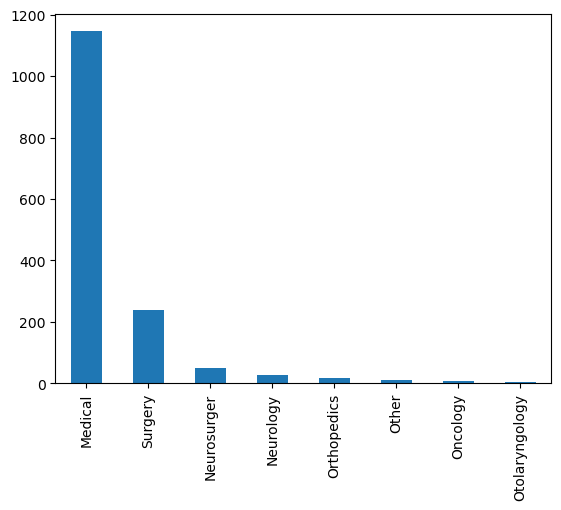

In [105]:

df_triage_t["EMRGgroup"] = df_triage_t.EMRGgroup.map(emr_map)
df_triage_t["EMRGgroup"].value_counts().plot(kind='bar')

In [106]:
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 39523 to 303814
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               1503 non-null   datetime64[ns]
 1   akdb_UtAkutt                1503 non-null   datetime64[ns]
 2   EMRGgroup                   1503 non-null   object        
 3   Htriage                     1503 non-null   object        
 4   Dischgto                    1503 non-null   object        
 5   akdb_ESS                    1498 non-null   object        
 6   pasient_Fødselsdato         1503 non-null   datetime64[ns]
 7   pasient_Dødsdato            1503 non-null   datetime64[ns]
 8   Kjonn                       1503 non-null   object        
 9   nimes_FagområdeBeskrivelse  1503 non-null   object        
 10  nimes_IK4489Kode            1503 non-null   object        
 11  nimes_IK4489Beskrivelse     1503 non-null   object

### Group Age

In [107]:
df_triage_t.Age= df_triage_t.Age.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins = [0,18,30,40,50,60,70,80,90,100,200]
labels = ['0-17','18-29', '30-39','40-49','50-59','60-69','70-79','80-89','90-100','+100']
df_triage_t['AgeGrp'] = pd.cut(df_triage_t.Age, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})

In [108]:
#df_triage_t['AgeGrpDesc'].value_counts()
df_triage_t[df_triage_t['AgeGrp'].isnull()]

,akdb_InnAkutt,akdb_UtAkutt,EMRGgroup,Htriage,Dischgto,akdb_ESS,pasient_Fødselsdato,pasient_Dødsdato,Kjonn,nimes_FagområdeBeskrivelse,...,EDLOS,Age,30dmrt,24hmrt,DischICU,Time_in_h,Ukedag,Mrt_AND_OR_ICU,Dischhome,AgeGrp


In [109]:
#df_triage_t['AgeGrpDesc'].value_counts()

### Group Triage score 

In [110]:
#df_triage_t['Htriage']= df_triage_t['Htriage'].astype(float).astype(int)
#df_triage_t['HtriageGrp'] = np.where(df_triage_t['Htriage']<3,1,0)
df_triage_t['HtriageGrp'] =df_triage_t.Htriage.map({'Grønn':'1'
                                                      ,'Blå':'1'
                                                       ,'Rød':'0'
                                                      ,'Oransje':'0'
                                                      ,'Gul':'1'
                                                     
                                                     
                                                     })
df_triage_t['HtriageGrpDesc'] =df_triage_t.Htriage.map({'Grønn':'Routine'
                                                      ,'Blå':'Routine'
                                                       ,'Rød':'Urgent'
                                                      ,'Oransje':'Urgent'
                                                      ,'Gul':'Routine'
                                                     
                                                     
                                                     })
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 39523 to 303814
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               1503 non-null   datetime64[ns]
 1   akdb_UtAkutt                1503 non-null   datetime64[ns]
 2   EMRGgroup                   1503 non-null   object        
 3   Htriage                     1503 non-null   object        
 4   Dischgto                    1503 non-null   object        
 5   akdb_ESS                    1498 non-null   object        
 6   pasient_Fødselsdato         1503 non-null   datetime64[ns]
 7   pasient_Dødsdato            1503 non-null   datetime64[ns]
 8   Kjonn                       1503 non-null   object        
 9   nimes_FagområdeBeskrivelse  1503 non-null   object        
 10  nimes_IK4489Kode            1503 non-null   object        
 11  nimes_IK4489Beskrivelse     1503 non-null   object

<AxesSubplot:>

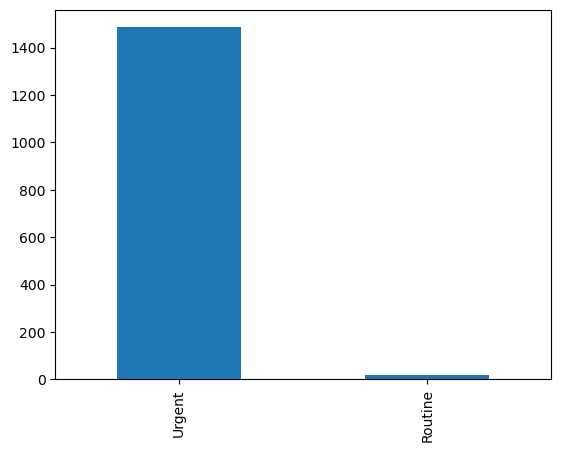

In [111]:
df_triage_t['HtriageGrpDesc'].value_counts().plot(kind='bar')

In [113]:
#df_triage_t.loc[(df_triage_t['HtriageGrpDesc']=='Urgent') ].info()
df_triage_t.loc[(df_triage_t['HtriageGrpDesc']=='Urgent') & (df_triage_t['24hmrt']==0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 39523 to 303814
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               925 non-null    datetime64[ns]
 1   akdb_UtAkutt                925 non-null    datetime64[ns]
 2   EMRGgroup                   925 non-null    object        
 3   Htriage                     925 non-null    object        
 4   Dischgto                    925 non-null    object        
 5   akdb_ESS                    924 non-null    object        
 6   pasient_Fødselsdato         925 non-null    datetime64[ns]
 7   pasient_Dødsdato            925 non-null    datetime64[ns]
 8   Kjonn                       925 non-null    object        
 9   nimes_FagområdeBeskrivelse  925 non-null    object        
 10  nimes_IK4489Kode            925 non-null    object        
 11  nimes_IK4489Beskrivelse     925 non-null    object 

## Group time of admission

In [202]:
df_triage_t.Time_in_h.value_counts()

11.0    728
12.0    706
13.0    689
14.0    687
15.0    675
10.0    648
17.0    639
16.0    617
19.0    616
21.0    616
20.0    613
18.0    592
22.0    588
0.0     528
9.0     521
23.0    485
1.0     457
2.0     444
3.0     368
4.0     351
8.0     344
7.0     302
6.0     281
5.0     275
Name: Time_in_h, dtype: int64

<AxesSubplot:>

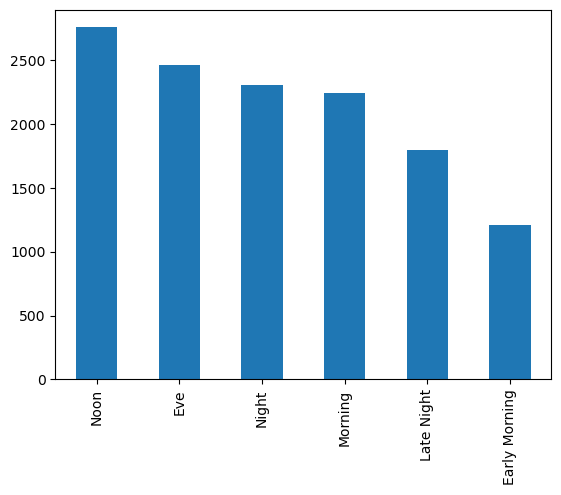

In [203]:
df_triage_t['Admtime']= df_triage_t.Time_in_h.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins =  [0,4,8,12,16,20,24]
labels = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df_triage_t['AdmtimeGrp'] = pd.cut(df_triage_t.Admtime, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})                                                  
df_triage_t['AdmtimeGrp'].value_counts().plot(kind='bar')

<AxesSubplot:>

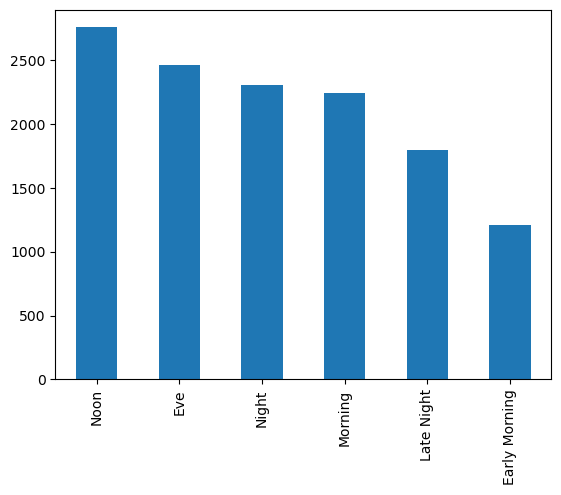

In [204]:
df_triage_t['AdmtimeGrp'].value_counts().plot(kind='bar')

In [205]:


#df_triage_t.Time_in_h= pd.to_datetime(df_triage_t.Time_in_h)
#df_triage_t.Time_out= pd.to_datetime(df_triage_t.Time_out)

In [206]:

#df_triage_t['Time_in_h']=df_triage_t.Time_in.dt.strftime('%H')
#df_triage_t['Time_in_m']=df_triage_t.Time_in.dt.strftime('%M')
#df_triage['Time_in_s']=df_triage.Time_in.dt.strftime('%S').astype(int)
#df_triage_t["Time_in_h"].value_counts().plot(kind='bar')

In [207]:

#df_triage_t['Time_out_h']=df_triage_t.Time_out.dt.strftime('%H')
#df_triage_t['Time_out_m']=df_triage_t.Time_out.dt.strftime('%M')
#df_triage['Time_out_s']=df_triage.Time_out.dt.strftime('%S').astype(int)


In [208]:
#df_triage_t.drop(['Time_in','Time_out'], axis=1, inplace=True)

In [209]:
for c in df_triage_t.select_dtypes(include='object'):
    df_triage_t[c] = df_triage_t[c].astype('string')
#df_triage_t[categorical_features].info()
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12770 entries, 2892 to 303893
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                12770 non-null  datetime64[ns]
 2   EMRGgroup                   12770 non-null  string        
 3   Htriage                     12770 non-null  string        
 4   Dischgto                    12770 non-null  string        
 5   akdb_ESS                    12748 non-null  string        
 6   pasient_Fødselsdato         12770 non-null  datetime64[ns]
 7   pasient_Dødsdato            5499 non-null   datetime64[ns]
 8   Kjonn                       12770 non-null  string        
 9   nimes_FagområdeBeskrivelse  12770 non-null  string        
 10  nimes_IK4489Kode            12770 non-null  string        
 11  nimes_IK4489Beskrivelse     12749 non-null  string

### Correlation

In [236]:
#from dython.nominal import associations
# compute_only = True means that we don't want to plot the heatmap
#fig, ax = plt.subplots(figsize=(16, 8))
#correlation_dictionary = associations(df_triage_t[numerical_features+categorical_features], numerical_columns = numerical_features,nominal_columns = categorical_features, mark_columns = False, 
#                num_num_assoc = 'pearson', nan_strategy = 'drop_samples',  figsize= (15, 15), vmin = 0, vmax=0.8, compute_only = True)
#correlation_dictionary["corr"].round(2) 

In [77]:

#bins = [0,10,20,30, 40, 50, 60, 70, 120]
#labels = ['0-9','10-19', '20-29','30-39', '40-49', '50-59', '60-69', '70+']
#df_triage_t['ageGrp'] = pd.cut(df_triage_t.Age.astype(float), bins, labels = labels,include_lowest = True)

## Cluster Sampling
##### https://github.com/AntonsRuberts/datascience_marketing/blob/master/KMeans_vs_KPrototypes.ipynb


In [576]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
#from functions import display_factorial_planes,display_parallel_coordinates,display_parallel_coordinates_centroids
from plotnine import *
import plotnine

In [605]:
features = [#'HtriageGrp' , 
             # 'Dischgto'
            # 'Dischhome', 
            #'DischICU', 
            'EMRGgroup',
        'Kjonn', 'ICD10Kapittel',
          #  'Aar' correlated to triagestmt
        #    'Mnd',
    #'Season',
      # 'DOW', #'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
            'AgeGrp',
           # '24hmrt',
      # '7dmrt', '30dmrt',
        #    'Triagestm', 
         #  'Time_in_h'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
nominal_features=[#'Dischgto', 
  
                  #'Dischhome'#, 'DischICU'
                  'EMRGgroup',
        'Kjonn',  'ICD10Kapittel'
     #  'DOW', # 'nprDiagn', 'Out_ICD10-chapter',
    #'24hmrt'#,'Season'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[#'HtriageGrp', 
          #        'Aar'
                   #'Mnd',
      'AgeGrp',  #'Time_in_h'#'Triagestm'
     # 'Shift'#, 'Time_in_m', 
       #'Time_out_h', 'Time_out_m'
                 ]

In [606]:
features

['EMRGgroup', 'Kjonn', 'ICD10Kapittel', 'AgeGrp']

In [607]:

df_triage_c = df_triage_t.copy()
df_triage_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12770 entries, 2892 to 303893
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                12770 non-null  datetime64[ns]
 2   EMRGgroup                   12770 non-null  string        
 3   Htriage                     12770 non-null  string        
 4   Dischgto                    12770 non-null  string        
 5   akdb_ESS                    12748 non-null  string        
 6   pasient_Fødselsdato         12770 non-null  datetime64[ns]
 7   pasient_Dødsdato            5499 non-null   datetime64[ns]
 8   Kjonn                       12770 non-null  string        
 9   nimes_FagområdeBeskrivelse  12770 non-null  string        
 10  nimes_IK4489Kode            12770 non-null  string        
 11  nimes_IK4489Beskrivelse     12749 non-null  string

In [608]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()


for c in ordinal_features:
 df_triage_c[c] = le.fit_transform(df_triage_c[c])

for c in ordinal_features:
    df_triage_c[c] = df_triage_c[c].astype('float64')


In [609]:
#df_triage_c = df_triage_c[features]

In [610]:

#imputer = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='most_frequent')
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
#imputer = imp_constant(random_state=42)
#imputer.fit(df_triage_c[nominal_features])
#df_triage_c[nominal_features] = imputer.transform(pd.DataFrame(df_triage_c, columns=nominal_features))

#imputer = SimpleImputer(missing_values=np.nan, strategy='median')
#imputer.fit(df_triage_c[ordinal_features])
#df_triage_c[ordinal_features] = imputer.transform(pd.DataFrame(df_triage_c, columns=ordinal_features))

In [611]:
data = df_triage_c.copy()
for c in ordinal_features:
    data[c] = data[c].astype('category')
for c in ordinal_features:
   pt = PowerTransformer()
   data[c] =  pt.fit_transform(np.array(data[c]).reshape(-1, 1))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12770 entries, 2892 to 303893
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                12770 non-null  datetime64[ns]
 2   EMRGgroup                   12770 non-null  string        
 3   Htriage                     12770 non-null  string        
 4   Dischgto                    12770 non-null  string        
 5   akdb_ESS                    12748 non-null  string        
 6   pasient_Fødselsdato         12770 non-null  datetime64[ns]
 7   pasient_Dødsdato            5499 non-null   datetime64[ns]
 8   Kjonn                       12770 non-null  string        
 9   nimes_FagområdeBeskrivelse  12770 non-null  string        
 10  nimes_IK4489Kode            12770 non-null  string        
 11  nimes_IK4489Beskrivelse     12749 non-null  string

In [612]:
data=data[features]

In [613]:
# Get the position of categorical columns
catColumnsPos = [data.columns.get_loc(col) for col in nominal_features]
print('Categorical columns           : {}'.format(nominal_features))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['EMRGgroup', 'Kjonn', 'ICD10Kapittel']
Categorical columns position  : [0, 1, 2]


In [614]:
data.head()

,EMRGgroup,Kjonn,ICD10Kapittel,AgeGrp
2892,NKIR,Mann,S00-S09,-0.845507
35853,MED,Kvinne,I30-I52,-1.838052
35947,MED,Kvinne,I30-I52,0.944183
36143,NEVRO,Mann,I70-I79,-0.845507
36905,KIR,Mann,S00-S09,-0.845507


In [615]:
dfMatrix = data.to_numpy()
dfMatrix

array([['NKIR', 'Mann', 'S00-S09', -0.8455065340727285],
       ['MED', 'Kvinne', 'I30-I52', -1.8380523680642016],
       ['MED', 'Kvinne', 'I30-I52', 0.9441827364153532],
       ...,
       ['MED', 'Mann', 'I30-I52', 0.9441827364153532],
       ['MED', 'Mann', 'I70-I79', 0.9441827364153532],
       ['MED', 'Mann', 'F10-F19', -0.8455065340727285]], dtype=object)

### Elbow method ( decide the number of clusters)

The elbow method is a useful graphical tool to estimate the optimal number of clusters k for a given task. Intuitively, we can say that, if k increases, the within-cluster SSE (“distortion”) will decrease. This is because the samples will be closer to the centroids they are assigned to.

The idea behind the elbow method is to identify the value of k where the distortion begins to decrease most rapidly, which will become clearer if we plot the distortion for different values of k:

In [470]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 11):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Cao', random_state = 49)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10


In [471]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 11), 'Cost':cost})
df_cost.head(10)

,Cluster,Cost
0,1,190929.000000
1,2,142165.587991
2,3,111016.353936
3,4,95876.930424
4,5,83554.317713
5,6,75939.683968
6,7,70595.479578
7,8,65207.836368
8,9,62084.983436
9,10,59236.609286


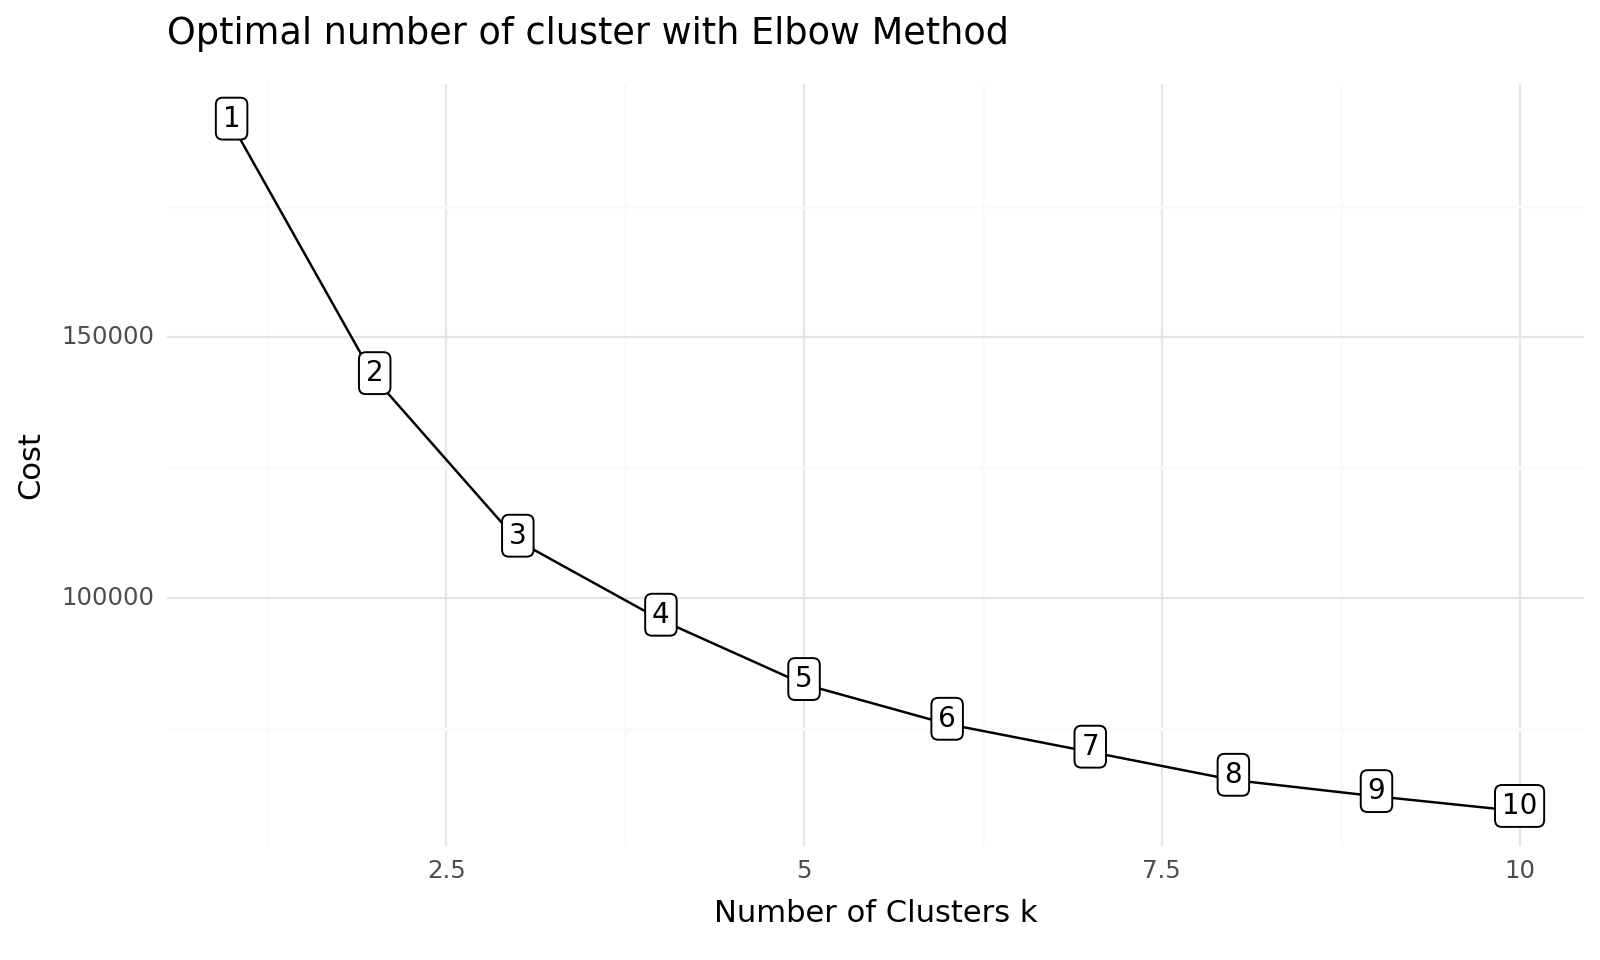

<Figure Size: (800 x 480)>

In [472]:


# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [473]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
from kneed import KneeLocator
cost_knee_c3  = KneeLocator(
        range(1,11), 
        cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_inertia_b3 = cost_knee_c3 .elbow   
print("elbow at k =", f'{K_inertia_b3:.0f} clusters')

elbow at k = 4 clusters


As we can see in the resulting plot, the elbow is located at k = 4, which is evidence that k = 3 is indeed a good choice for this dataset.

### Performing Clustering

In [616]:
# Fit the cluster
#kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
#kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

kprototype = KPrototypes(n_clusters=3 , init = 'Cao', n_jobs = -1)
clusters = kprototype.fit_predict(dfMatrix, categorical=catColumnsPos)

In [617]:
pd.Series(clusters).value_counts()

0    6266
2    3368
1    3136
dtype: int64

In [630]:
df_triage_clustered = pd.DataFrame(df_triage_t, columns=df_triage_t.columns, index=df_triage_t.index)
df_triage_clustered['clusters'] = clusters
data['clusters']= clusters


#data_clustered['kjonn'] = le_kjonn.inverse_transform(data_clustered['kjonn'] )
#data_clustered['tilst1akse1'] = le_tilstand.inverse_transform(data_clustered['tilst1akse1'] )
df_triage_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12770 entries, 2892 to 303893
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                12770 non-null  datetime64[ns]
 2   EMRGgroup                   12770 non-null  string        
 3   Htriage                     12770 non-null  string        
 4   Dischgto                    12770 non-null  string        
 5   akdb_ESS                    12748 non-null  string        
 6   pasient_Fødselsdato         12770 non-null  datetime64[ns]
 7   pasient_Dødsdato            5499 non-null   datetime64[ns]
 8   Kjonn                       12770 non-null  string        
 9   nimes_FagområdeBeskrivelse  12770 non-null  string        
 10  nimes_IK4489Kode            12770 non-null  string        
 11  nimes_IK4489Beskrivelse     12749 non-null  string

In [619]:


def cluster_profile(df):
    dfc = df.groupby("clusters").agg({ 
      
       # "EDLOS": "median",
      
  
        
        #"Phtriage": lambda x: x.value_counts().index[0],
        "HtriageGrpDesc": lambda x: x.value_counts().index[0],
        
        #    "Triagestm": lambda x: x.value_counts().index[0],
        #"24hmrt": lambda x: x.value_counts().index[0],
        "AgeGrpDesc": lambda x: x.value_counts().index[0],
      
       # "7dmrt": lambda x: x.value_counts().index[0],
       # "30dmrt": lambda x: x.value_counts().index[0],
     
       
         # "Dischhome": lambda x: x.value_counts().index[0],
   
         # "EMRGgroup": lambda x: x.value_counts().index[0],
      
        
     "Kjonn": lambda x: x.value_counts().index[0],
       
         "EMRGgroup_1": lambda x: x.value_counts().index[0],
         "EMRGgroup_2": lambda x: x.value_counts().index[1],
         "EMRGgroup_3": lambda x: x.value_counts().index[2],
       
         "ICD10Kapittel_1": lambda x: x.value_counts().index[0],
         "ICD10Kapittel_2": lambda x: x.value_counts().index[1],
         "ICD10Kapittel_3": lambda x: x.value_counts().index[2],
    #    "Out_ICD10-chapter_1": lambda x: x.value_counts().index[0],
     #   "Out_ICD10-chapter_2": lambda x: x.value_counts().index[1],
      #  "Out_ICD10-chapter_3": lambda x: x.value_counts().index[2],
     
     #    "Season": lambda x: x.value_counts().index[0],
       #  "DOW": lambda x: x.value_counts().index[0],
      #   "ShiftDesc": lambda x: x.value_counts().index[0],
       #  "Time_in_h": lambda x: x.value_counts().index[0],
       #  "Time_out_h": lambda x: x.value_counts().index[0]
      
                                    })    .sort_values(by=['HtriageGrpDesc'], ascending=False)

   # df[nominal_features+numerical_features+['cluster']].groupby(["cluster"]).agg(lambda x:x.value_counts().index[0])
    return dfc

In [620]:
df = df_triage_clustered.copy()
df['ICD10Kapittel_1']=df['ICD10Kapittel']
df['ICD10Kapittel_2']=df['ICD10Kapittel']
df['ICD10Kapittel_3']=df['ICD10Kapittel']




df['EMRGgroup_1']=df['EMRGgroup']
df['EMRGgroup_2']=df['EMRGgroup']
df['EMRGgroup_3']=df['EMRGgroup']
#df['Out_ICD10-chapter_1']=df['Out_ICD10-chapter']
#df['Out_ICD10-chapter_2']=df['Out_ICD10-chapter']
#df['Out_ICD10-chapter_3']=df['Out_ICD10-chapter'] 

In [621]:
cluster_profile(df)

,HtriageGrpDesc,AgeGrpDesc,Kjonn,EMRGgroup_1,EMRGgroup_2,EMRGgroup_3,ICD10Kapittel_1,ICD10Kapittel_2,ICD10Kapittel_3
clusters,,,,,,,,,
0,Urgent,Adult,Mann,MED,KIR,NEVRO,F10-F19,S00-S09,I60-I69
1,Urgent,Older,Kvinne,MED,KIR,ORT,J40-J47,I30-I52,J09-J18
2,Urgent,Older,Mann,MED,KIR,NKIR,I30-I52,J09-J18,I20-I25


In [597]:
mydf = df_triage_clustered[ df_triage_clustered.clusters==0]
mydf.HtriageGrpDesc.value_counts()

Urgent    6154
Name: HtriageGrpDesc, dtype: Int64

## Classification evaluation

In [210]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import shap
shap.initjs()

In [211]:
features = ['HtriageGrp' , 
             # 'Dischgto'
            # 'Dischhome', 
            #'DischICU', 
            'EMRGgroup',
        'Kjonn', #'InICD10-chapter',
          #  'Aar' correlated to triagestmt
        #    'Mnd',
    #'Season',
      # 'DOW', #'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
            'AgeGrp',
          #  '24hmrt',
      # '7dmrt', '30dmrt',
        #    'Triagestm', 
           'AdmtimeGrp'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
nominal_features=[#'Dischgto', 
                  #'Dischhome'#, 'DischICU'
                  'EMRGgroup', 'AdmtimeGrp',
        'Kjonn',  #'InICD10-chapter',
     #  'DOW', # 'nprDiagn', 'Out_ICD10-chapter',
    '24hmrt'#,'Season'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[ #'HtriageGrp', 
   
          #        'Aar'
                   #'Mnd',
      'AgeGrp', #'Time_in_h'# 'Time_in_h'#'Triagestm'
     # 'Shift'#, 'Time_in_m', 
       #'Time_out_h', 'Time_out_m'
                 ]

In [212]:
data = df_triage_t[features]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12770 entries, 2892 to 303893
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HtriageGrp  12770 non-null  string  
 1   EMRGgroup   12770 non-null  string  
 2   Kjonn       12770 non-null  string  
 3   AgeGrp      12770 non-null  category
 4   AdmtimeGrp  12770 non-null  category
dtypes: category(2), string(3)
memory usage: 424.6 KB


In [213]:
#load data 
data = df_triage_t[features]

#get features
y = data['HtriageGrp']
y = y.astype('category').cat.codes
X_cat = data.drop('HtriageGrp', axis=1)

In [214]:
#fit encoder
enc = OneHotEncoder()
enc.fit(X_cat)

#transform categorical features
X_encoded = enc.transform(X_cat).toarray()

#create feature matrix
feature_names = X_cat.columns
new_feature_names = enc.get_feature_names_out(feature_names)

X = pd.DataFrame(X_encoded, columns= new_feature_names)

In [215]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y
)
#class_weight=int(y.value_counts()[0]/y.value_counts()[1])

In [216]:

#Train model
model = xgb.XGBClassifier(objective="binary:logistic",  
                         max_depth=2, 
                         n_estimators=10)
#model =  RandomForestClassifier(random_state=42,class_weight="balanced")
model.fit(X, y,sample_weight=classes_weights)
#model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Standard SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


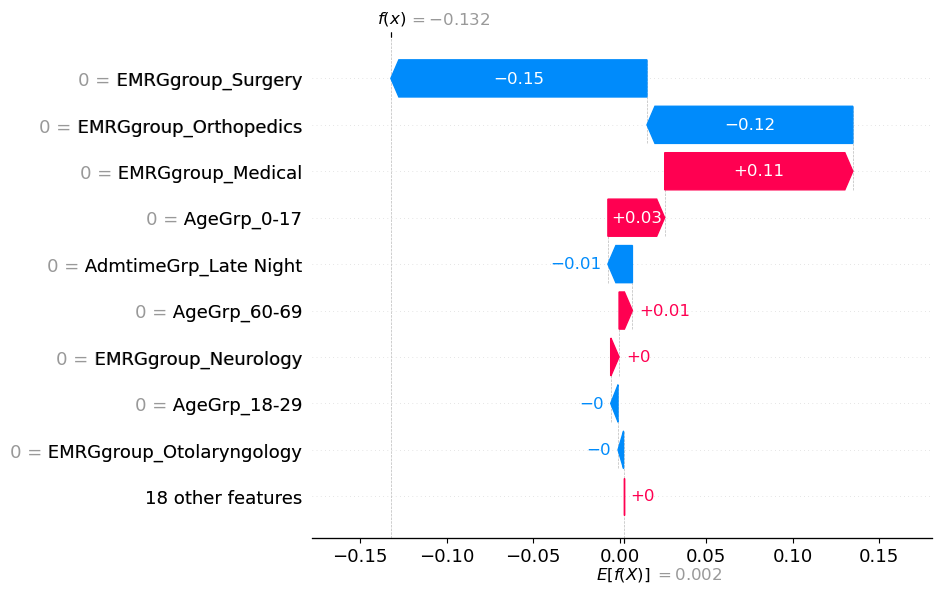

In [217]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

### SHAP for categorical features

In [218]:

print(shap_values)

.values =
array([[ 0.        ,  0.1087552 ,  0.00484569, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.02894509,  0.00429105, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.08503874,  0.00429105, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.08503874,  0.00429105, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.08503874,  0.00429105, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.08503874,  0.00429105, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

.base_values =
array([0.00223453, 0.00223453, 0.00223453, ..., 0.00223453, 0.00223453,
       0.00223453], dtype=float32)

.data =
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0.,

In [219]:
print(shap_values.values[0])

[ 0.          0.1087552   0.00484569  0.          0.         -0.11900906
  0.         -0.00317381 -0.14804481  0.          0.          0.
  0.03284429 -0.00424965  0.          0.          0.          0.00772172
  0.          0.          0.          0.          0.         -0.01418285
  0.          0.          0.        ]


add the SHAP values for each categorical feature together.

In [220]:
#get number of unique categories for each feature 
n_categories = []
for feat in feature_names[:-1]:
    n = X_cat[feat].nunique()
    n_categories.append(n)

In [221]:
new_shap_values = []
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values.append(values_sum)

In [222]:
#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values.data = np.array(new_data)

#update feature names
shap_values.feature_names = list(X_cat.columns)

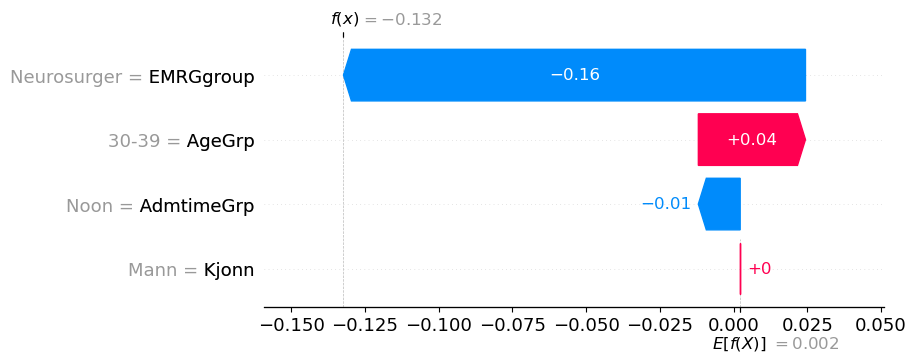

In [223]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

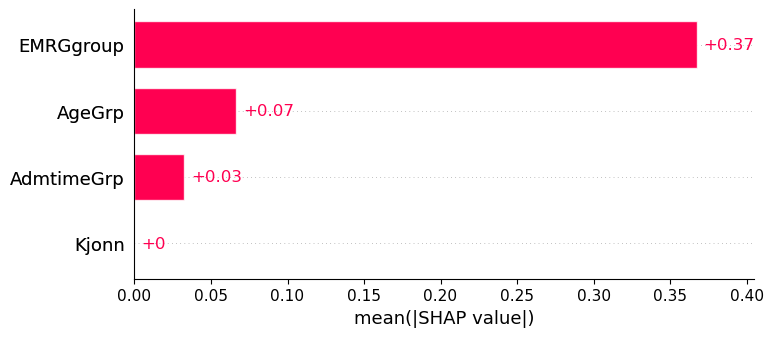

In [224]:
#Mean SHAP
shap.plots.bar(shap_values)

Text(0.5, 0, 'Emergency_Group')

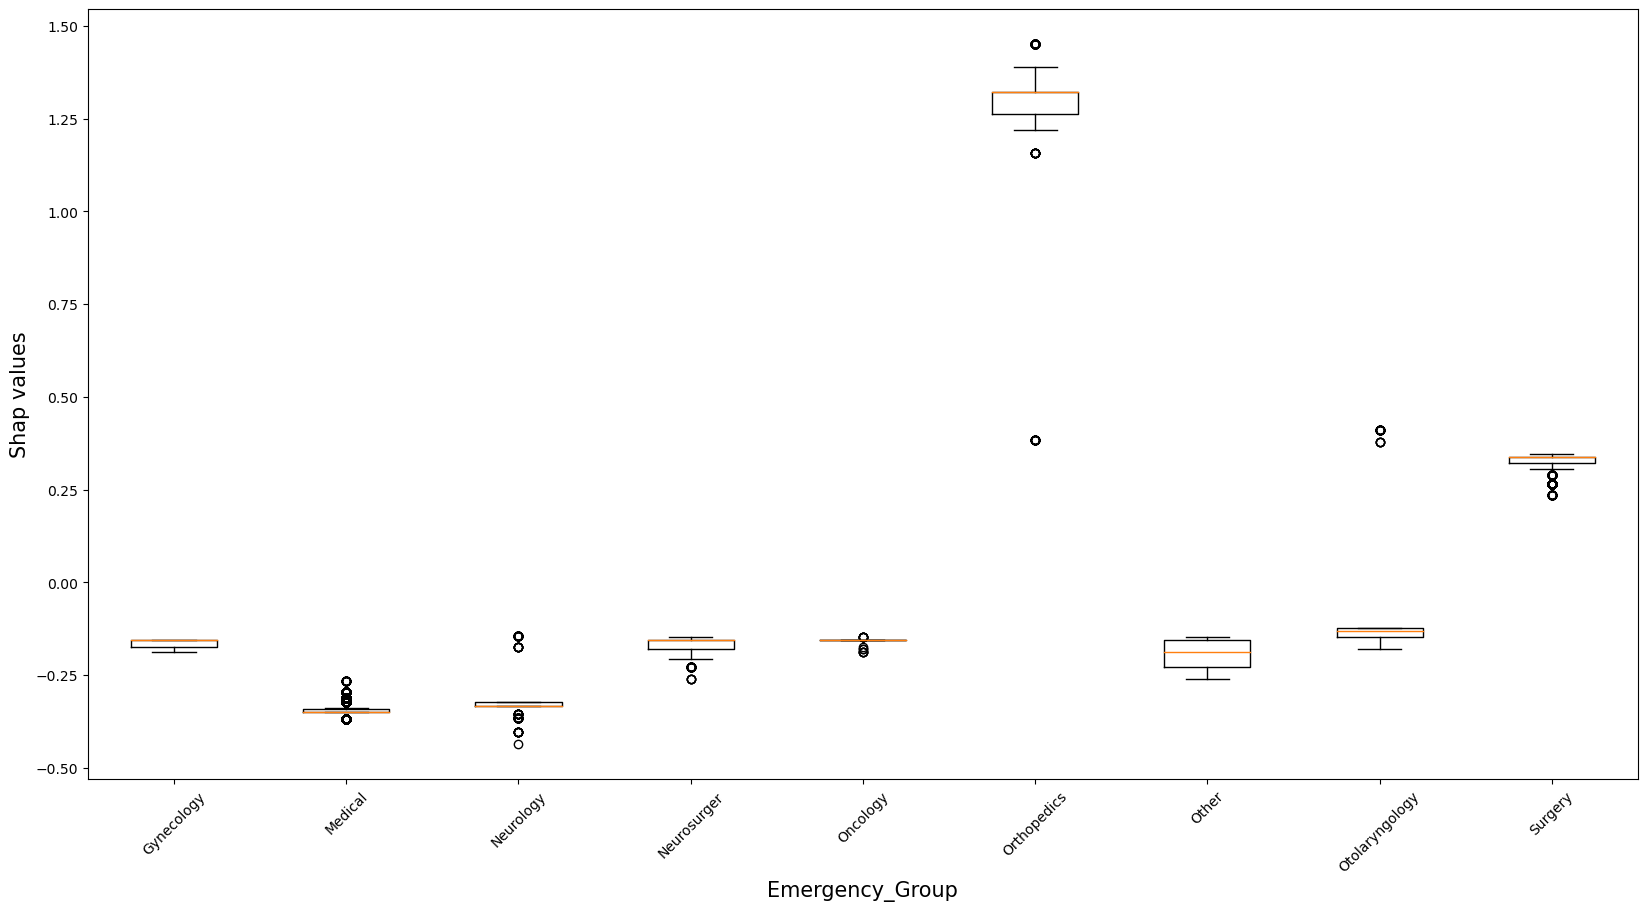

In [226]:
#split EMRGgroup shap values based on odor category

emrg_values = shap_values[:,"EMRGgroup"].values
emrg_data = shap_values[:,"EMRGgroup"].data
emrg_categories = sorted(list(set(emrg_data)), key=str.lower)

emrg_groups = []
for o in emrg_categories:
    relevant_values = emrg_values[emrg_data == o]
    emrg_groups.append(relevant_values)
    
#replace categories with labels

              
Emrg_labels = {'AKUTTPOL':'Emergency Pol',
               ' KRISE':'Disaster', 
               'MED':'MED', 
               'GYN':'Gynocolog',
               'ØNH':'Otorhinolaryngologi', 
                'LAB':'LAB',
               'KIR':'Chirurgy', 
               'ORT':'Ortopedy', 
               'NEVRO':'Neurological', 
               'MED':'Medical', 
               'KREFT':'Cancer',
               'Rett p† post':'To ward',
               'MULTITRAUME':'Multi-trauma',
               'KJKIR':'K chirurgy',
               'NKIR':'N chirurgy',
               'XXXX':'UNFILLED',
               'INFO':'INFO',
               'ANNET':'OTHER',
               'HUD':'Skin',
             #  'ØYE':'Eye',
               'AP NEVROKIR':'Neurochirurgie'
               
              
              
              
              
              
              }

labels =emrg_categories
#labels= [Emrg_labels[u] for u in emrg_categories]

#plot boxplot
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(emrg_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Emergency_Group',size=15)

In [227]:

#unique, counts = np.unique(ageGrp_data, return_counts=True)
#dict(zip(unique, counts))

0-17
18-29
30-39
40-49
50-59
60-69
70-79
80-89
90-100
+100


Text(0.5, 0, 'AgeGroup')

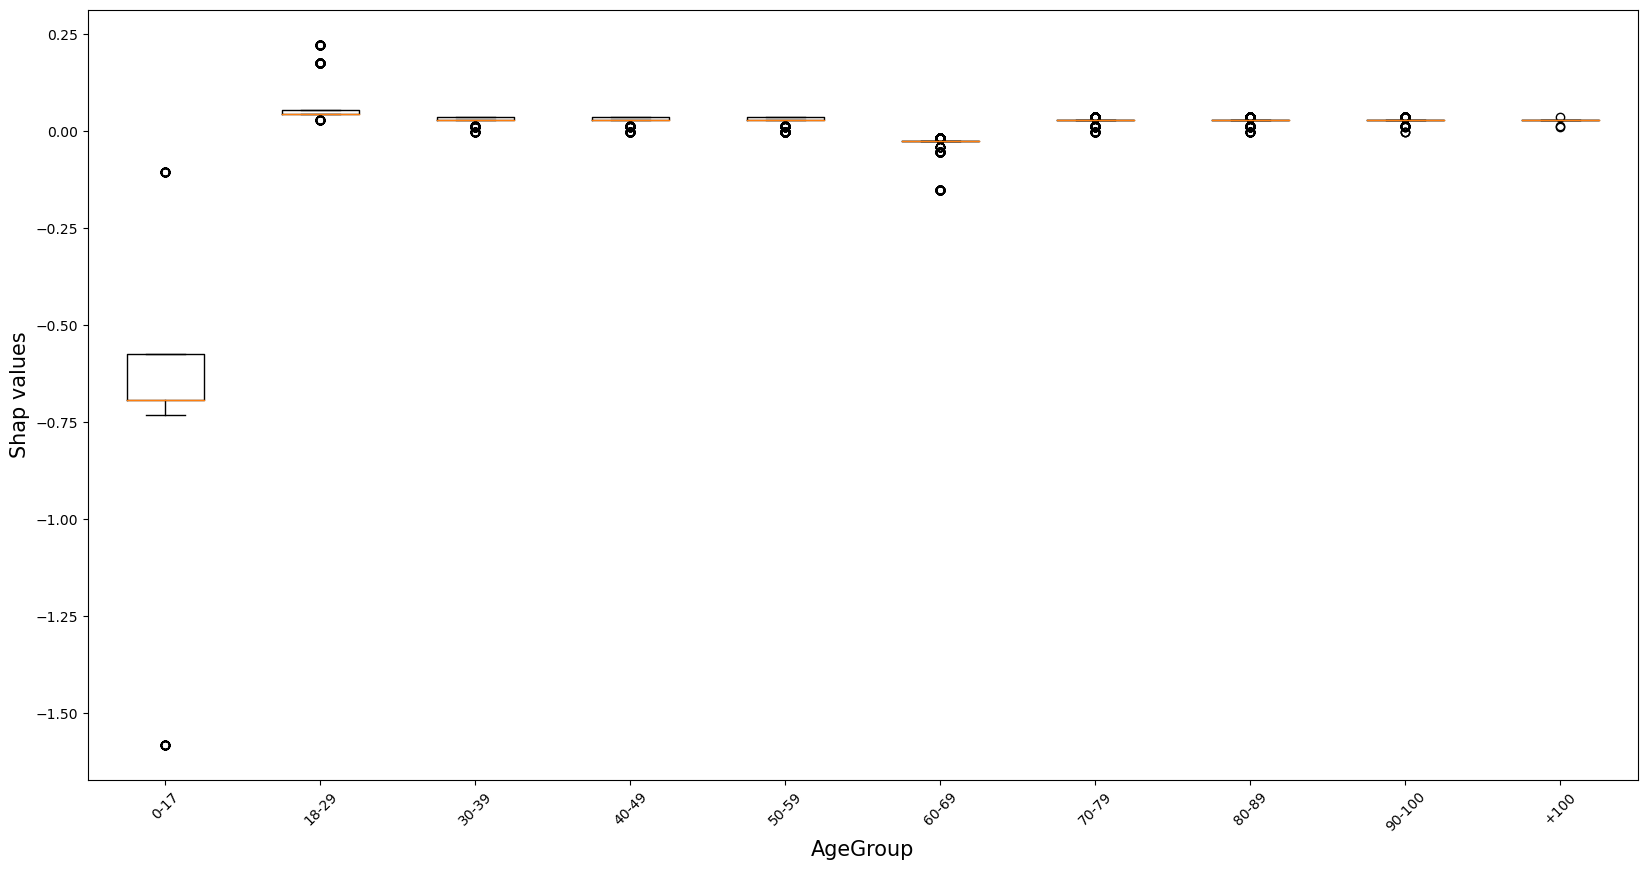

In [228]:
age_values = shap_values[:,"AgeGrp"].values
age_data = shap_values[:,"AgeGrp"].data
age_categories = list(set(age_data))
#print(age_categories)
age_categories = ['0-17','18-29', '30-39', '40-49', '50-59', '60-69', '70-79','80-89','90-100','+100']
age_groups = []
for o in age_categories:
    relevant_values = age_values[age_data == o]
    print(o)
    age_groups.append(relevant_values)


labels = age_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(age_groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('AgeGroup',size=15)

In [229]:
timeinH_categories=['Early Morning','Morning', 'Noon',   'Eve','Night', 'Late Night']

Text(0.5, 0, 'AdmtimeGrp')

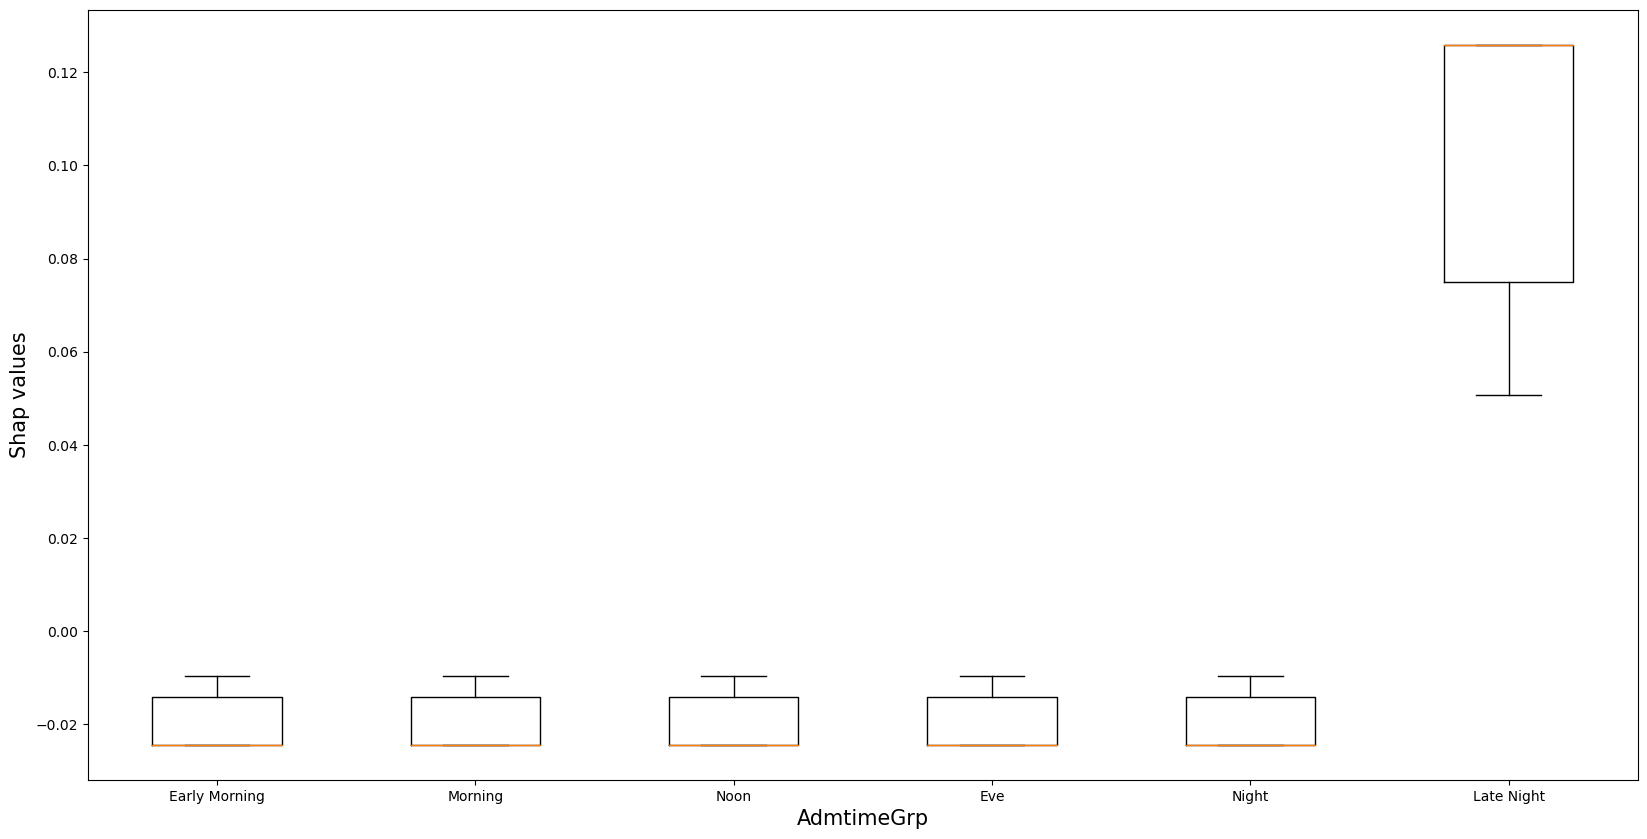

In [230]:
#split Time_in_h shap values based on AgeGroup category

timeinH_values = shap_values[:,"AdmtimeGrp"].values
timeinH_data = shap_values[:,"AdmtimeGrp"].data
#timeinH_categories = list(set(timeinH_data))

timeinH_groups = []
for o in timeinH_categories:
    relevant_values = timeinH_values[timeinH_data == o]
    timeinH_groups.append(relevant_values)
    


labels = timeinH_categories
#labels= [timeinH_labels[u] for u in timeinH_categories]

#plot boxplot
plt.figure(figsize=(20, 10))

plt.boxplot(timeinH_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('AdmtimeGrp',size=15)

Text(0.5, 0, 'Sex')

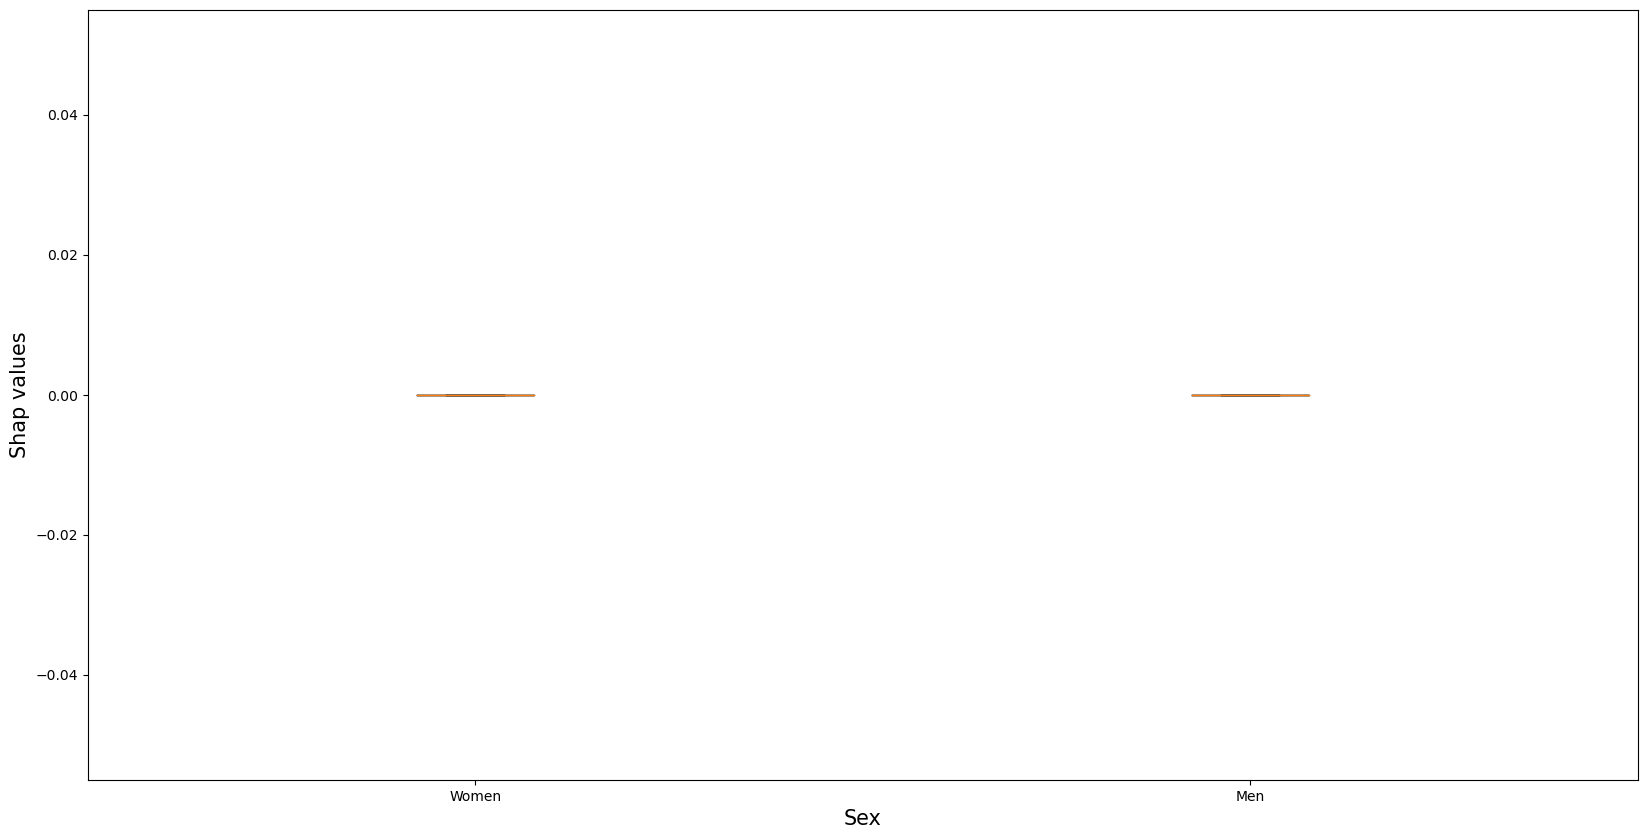

In [231]:
#split Time_in_h shap values based on AgeGroup category

Kjonn_values = shap_values[:,"Kjonn"].values
Kjonn_data = shap_values[:,"Kjonn"].data
Kjonn_categories = list(set(Kjonn_data))

Kjonn_groups = []
for o in Kjonn_categories:
    relevant_values = Kjonn_values[Kjonn_data == o]
    Kjonn_groups.append(relevant_values)
    
#replace categories with labels
Kjonn_labels = {'Kvinne':'Women',
                'Mann':'Men',
                'missing':'Missing'
               
              
              
              
              
              
              }

labels = Kjonn_categories
labels= [Kjonn_labels[u] for u in Kjonn_categories]

#plot boxplot
plt.figure(figsize=(20, 10))

plt.boxplot(Kjonn_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Sex',size=15)

In [144]:
df = df_triage_t.loc[df_triage_t['Kjonn']=="Kvinne"]
df['HtriageGrpDesc'].value_counts()#.plot(kind='bar')

Routine    18112
Urgent      6565
Name: HtriageGrpDesc, dtype: Int64

In [76]:
6876/16500

0.4167272727272727

In [78]:
6460/17798

0.36296213057646926